# Climate Change Exploration: Maunalua Bay, Oahu, Hawai'i
## Fall 2021
### Elmera Azadpour
### 2021-12-08
All scripts and data can be accessed from [Aloha Aina Repo](https://github.com/aloha-aina/Aloha-Aina-Master)

Code derived from [CMIP6 PanGeo Gallery](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/precip_frequency_change.html)

In [1]:
## import libraries:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
import s3fs
import kedro
import nc_time_axis
import plotly.express as px
import metpy
from metpy.units import units

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
## CMIP6 Public Data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head(50)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
5,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
6,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
7,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
8,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfss,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
9,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,evspsbl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
## Query for projection CMIP6 data
df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
len(df_3hr_pr)

run_counts = df_3hr_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id         experiment_id     
BCC-CSM2-MR       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1        highresSST-present     1
                  historical             3
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1-HR     highresSST-present     1
CNRM-ESM2-1       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
GFDL-CM4          1pctCO2                2
                  abrupt-4xCO2           2
                  amip                   2
                  historical             2
                  piControl              2
GFDL-CM4C192     

<div>
<center>
<img src="https://github.com/aloha-aina/Aloha-Aina-Master/blob/main/img/cmip6_ssp.png?raw=1" width="600"/>
<br>
Fig. 1: Future and historical CO2 emissions scenarios featured in CMIP6
<br>
Source: https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained
</center>
</div>
<br>

In [6]:
## querty for 3hr, precipitaion for ssp 2-4.5 from CNRM-ESM2-1
df_3hr_ssp245_CNRM_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr') & (df.experiment_id== 'ssp245') & (df.source_id== 'CNRM-ESM2-1') ]
len(df_3hr_ssp245_CNRM_pr)
df_3hr_ssp245_CNRM_pr 

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
69173,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp245,r1i1p1f2,3hr,pr,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190328


In [7]:
## pull data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_3hr_ssp245_CNRM_pr.zstore.values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds_proj = xr.open_zarr(mapper, consolidated=True)
ds_proj

gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp245/r1i1p1f2/3hr/pr/gr/v20190328/


<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, time: 251288, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 2015-01-01T01:30:00 ... 2100-12-31T22:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(62822, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_ssp245_r1i1p1f2
    activity_id:            ScenarioMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/215d187a-7fa5-41cd-a59b-7fe164306a61...
    version_id:             v20190328

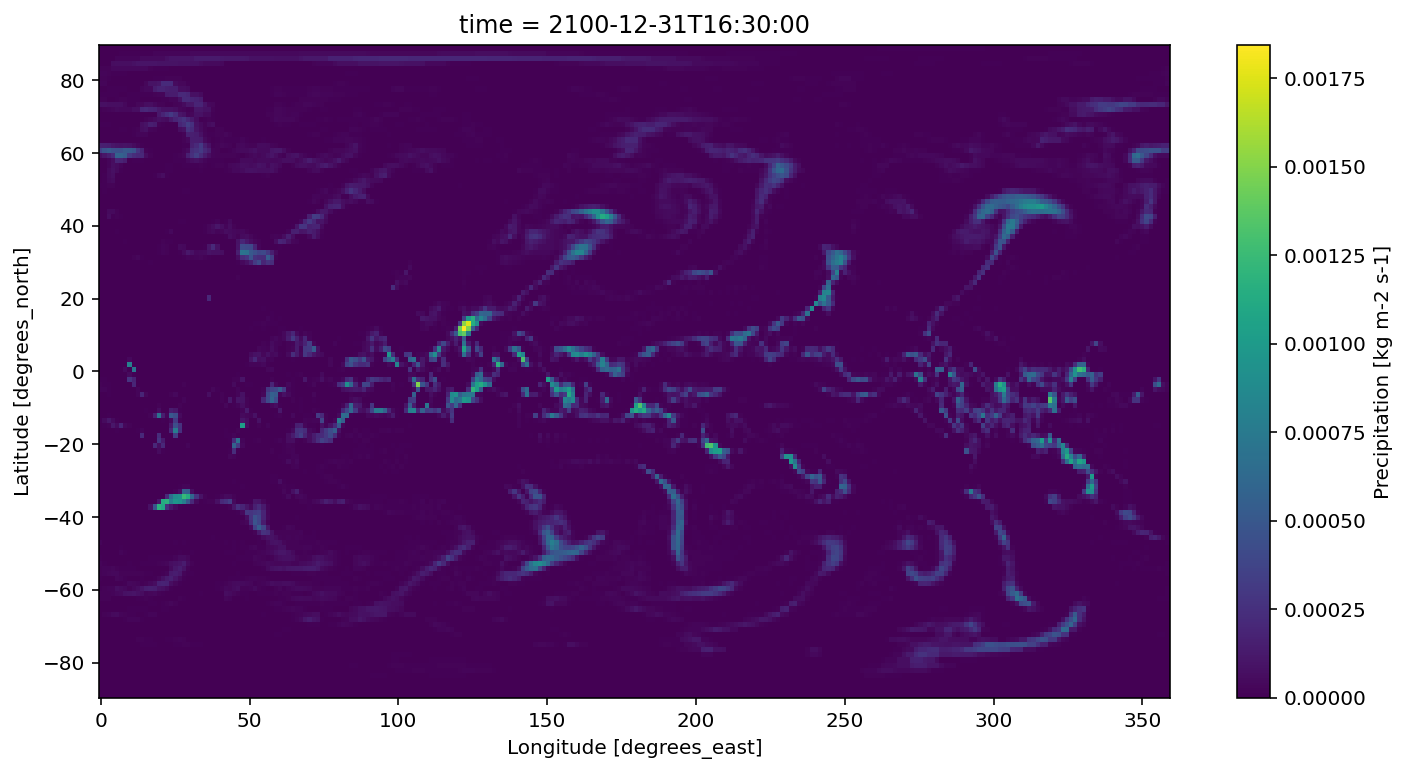

In [6]:
## Plot a map from a specific date: global coverage
ds_proj.pr.sel(time='2100-12-31T16:30:00.000000000').squeeze().plot()

In [8]:
# # Create logical masks for lat and lon variables for oahu 
# bouding box: -158.5698,20.9057,-157.406,22.0022
mask_lon = (ds_proj.pr.lon >= 201.43) & (ds_proj.pr.lon <= 202.59) 
mask_lat = (ds_proj.pr.lat >= 20.91) & (ds_proj.pr.lat <= 22.00)

## mask for Manalua Bay Region
## bouding box: -157.776173,21.253719,-157.701842,21.296411
## error when plotting: not enough values to unpack (expected 3, got 0)
## too small of area 
# mask_lon = (ds_proj.pr.lon >= 202.224) & (ds_proj.pr.lon <= 202.298) 
# mask_lat = (ds_proj.pr.lat >= 21.254) & (ds_proj.pr.lat <= 21.296)

# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr_proj=ds_proj.pr.where(mask_lon & mask_lat, drop = True)

# Make metpy recognize the units
oahu_pr_proj = oahu_pr_proj.metpy.quantify()

# convert kg/m2/sec to in/hour
density_water = units('kg / m^3') * 1000
oahu_pr_proj_converted_int = (oahu_pr_proj / density_water)
oahu_pr_proj_converted_int = oahu_pr_proj_converted_int.metpy.convert_units('inches / day')
oahu_pr_proj_converted_int = oahu_pr_proj_converted_int.mean("lon").mean("lat")
oahu_pr_proj_converted_int

<xarray.DataArray 'pr' (time: 251288)>
<Quantity(dask.array<mean_agg-aggregate, shape=(251288,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>, 'inch / day')>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T01:30:00 ... 2100-12-31T22:30:00

<div>
<center>
<img src="https://github.com/aloha-aina/Aloha-Aina-Master/blob/main/img/bb_oahu.png?raw=1" width="600"/>
<br>
Fig. 2: Bouding box coordinates used for projection analysis
<br>
Source: https://boundingbox.klokantech.com/
</center>
</div>
<br>

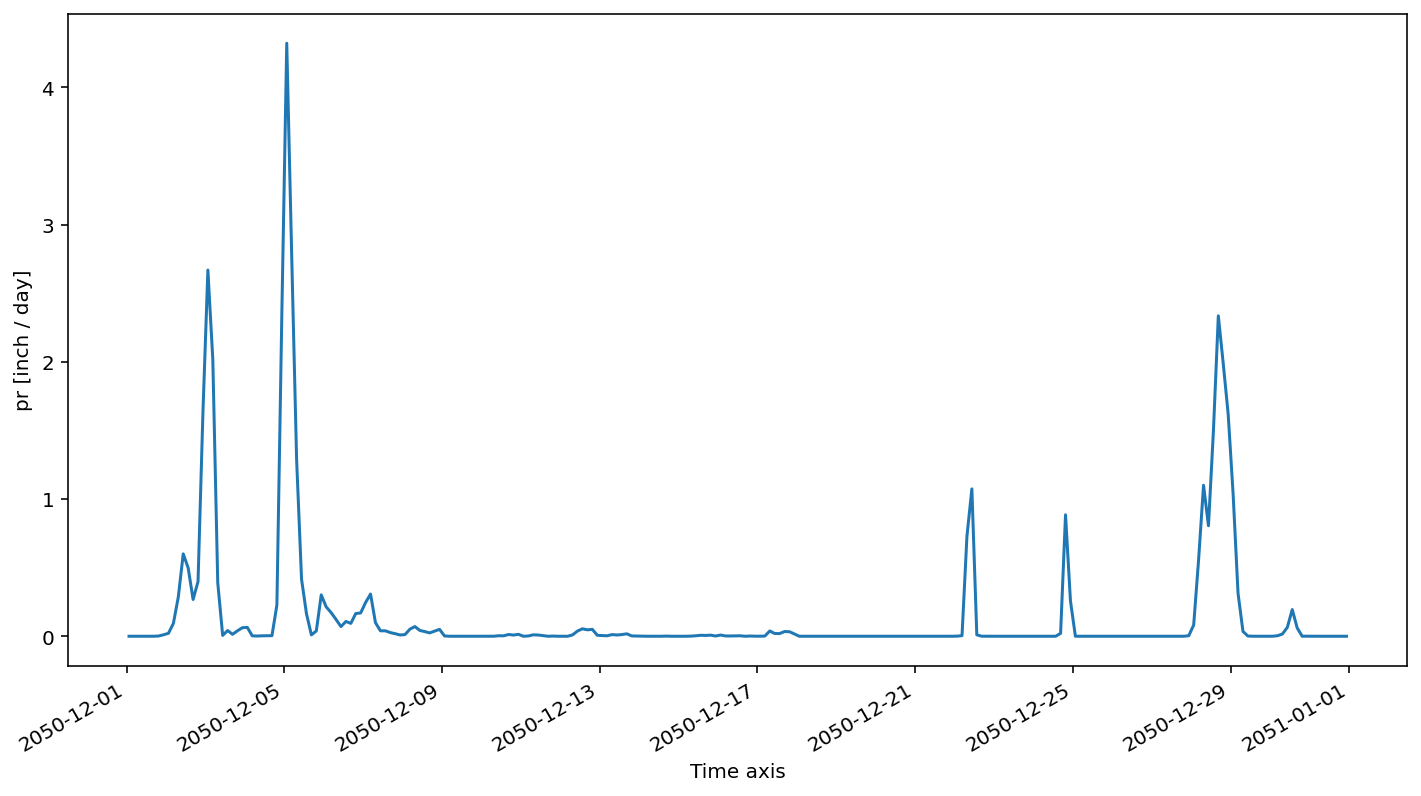

In [10]:
## Plot a plot from a projected date and lat and long for Oahu.
oahu_pr_proj_converted_int.sel(time='2050-12').squeeze().plot()

In [42]:
# Cast our 3 dimensional xarray to dataframe
oahu_pr_proj_df = oahu_pr_proj_converted_int.to_dataframe().reset_index()
oahu_pr_proj_df.head(20)
## Issue is 3hr time intervals but I converted kg/m^2/s to inches/day, I pressume that if I could just sum the 8 values you have for that day to have inches/day per day


,time,pr
0,2015-01-01 01:30:00,1.851410e-05
1,2015-01-01 04:30:00,5.754455e-07
2,2015-01-01 07:30:00,2.899172e-06
3,2015-01-01 10:30:00,1.021872e-04
4,2015-01-01 13:30:00,5.698807e-06
5,2015-01-01 16:30:00,2.303271e-23
6,2015-01-01 19:30:00,4.331510e-23
7,2015-01-01 22:30:00,8.842626e-23
8,2015-01-02 01:30:00,1.184089e-22
9,2015-01-02 04:30:00,1.803245e-23
